# 3.9.1: Baseball Iteration

---

<br>

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey, (License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/))

Revised, Mike Augspurger (2021-present)

<br>

---

In [ ]:
#@title
# Import necessary libraries
from os.path import basename, exists
from os import mkdir

def download(url,folder):
    filename = folder + basename(url)
    if not exists(folder):
        mkdir(folder)
    # fetches the file at the given url if it is not already present
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Notebooks/'
        + 'ModSimPy_Functions/modsim.py', 'ModSimPy_Functions/')

from ModSimPy_Functions.modsim import *
import pandas as pd
import numpy as np

Downloaded ModSimPy_Functions/modsim.py


The cell below contains any functions you might need from notebook 3.9.1:

In [ ]:
def angle_to_components(mag,angle):
    theta = np.deg2rad(angle)
    x = mag * np.cos(theta)
    y = mag * np.sin(theta)
    return pd.Series(dict(x=x,y=y),dtype=float)

def make_system(params):
    
    x, y, angle, speed, mass, diameter, C_d, rho, g, t_end = params.values()
    
    # compute x and y components of velocity
    init_vel = angle_to_components(speed, angle)
    
    # make the initial state
    init = pd.Series(dict(x=x, y=y, vx=init_vel.x, vy=init_vel.y))
    
    # compute the frontal area
    area = np.pi * (diameter/2)**2

    return dict(C_d=C_d, rho=rho, g=g, t_end=t_end,
                  mass=mass,
                  init = init,
                  area = area)
    
def drag_force(V, system):
    rho, C_d, area = system['rho'], system['C_d'], system['area']
    
    # Find the magnitude and direction of the velocity
    vel_mag = np.sqrt(V.x**2 + V.y**2)
    dir = V/vel_mag

    # Find the magnitude of the drag force
    drag_mag = rho * vel_mag**2 * C_d * area * (1/2)

    # Define the direction of the force as opposite that of the  velocity
    # Notice that "dir" is a vector, so f_drag is vector too
    f_drag = drag_mag * -dir

    return f_drag

def slope_func(t, state, system):
    x, y, vx, vy = state
    mass, g = system['mass'], system['g']
    
    V = pd.Series(dict(x=vx, y=vy),dtype=float)
    a_drag = drag_force(V, system) / mass

    # Acceleration has to be defined as a vector too
    a_grav = pd.Series(dict(x=0,y=-g),dtype=float)
    
    A = a_grav + a_drag
    
    return V.x, V.y, A.x, A.y  

def event_func(t, state, system):
    x, y, vx, vy = state
    return y

def plot_trajectory(results,label,**options):
    x = results.x.values
    y = results.y.values
    x_vs_y = pd.Series(data=y,index=x)
    x_vs_y.plot(label=label,xlabel='x position (m)',
             ylabel='y position (m)',figsize=[12,4],**options)

Now we'll run the simulation with a constant drag coefficient, so we can compare our results with a variable coefficient:

In [ ]:
params = dict(x = 0, y = 1,    
    angle = 45,     # degree
    speed = 40,     # m / s

    mass = 0.145,    # kg 
    diameter = 0.073, # m 
    C_d = 0.33,       # dimensionless

    rho = 1.2,      # kg/m**3
    g = 9.8,        # m/s**2
    t_end = 10)     # s

system = make_system(params)
results, details = run_solve_ivp(system, slope_func,
                                 events=event_func)

## Incorporating a Drag Function

 The model we built in notebook 3.9.1 is based on the assumption that coefficient of drag does not depend on velocity, but in reality it does.  The following figure, from Robert Adair's *The Physics of Baseball*, shows coefficient of drag as a function of velocity:

<br>

<img src = https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Images_and_Data/Images/baseball_drag.png width = 600>


  

The data in this plot is available in the following .csv file.  We'll pull it into a `DataFrame` so we can access it easily:

In [ ]:
filename = 'https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Images_and_Data/Data/baseball_drag.csv'
baseball_drag = pd.read_csv(filename)
baseball_drag.head()


,Velocity in mph,Drag coefficient
0,0.058486,0.49965
1,19.845000,0.49878
2,39.476000,0.49704
3,50.181000,0.48225
4,60.134000,0.45004


Let's convert miles per hour to meters per second.

In [ ]:
mph_to_mps = 0.44704
speed = baseball_drag['Velocity in mph'].values * mph_to_mps

Then we'll put the data in a `Series`, and plot it:

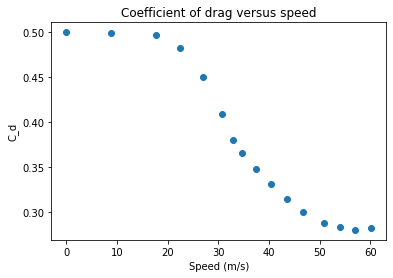

In [ ]:
data = baseball_drag['Drag coefficient'].values
C_d_series = pd.Series(data=data,index=speed)

C_d_series.plot(label='C_d', xlabel='Speed (m/s)', 
         ylabel='C_d', style='o',
         title='Coefficient of drag versus speed');

### Part 1

Clearly, we only have data points at defined speeds.  To use `run_solve_ivp`, we need to create a continuous function so we can access a $C_d$ value at any speed.  Create this function using `interp1d` (you can look at notebook 2.7.1 to remind yourself how to do this):

In [ ]:
# Create an interpolated function called "cd_func"
# Check that its value at 30 m/s is correct (about 0.41)
cd_func = interp1d(C_d_series.index,C_d_series.values)
cd_func(30)

array(0.41607879)

### Part 2

Ok, now make some adjustments to the model.  First, create a function called `drag_force_var` that takes a velocity vector V, the system, and the interpolated $C_d$ function as its parameters, and returns the drag force.  Start by copying and pasting the original `drag_force` function.

In [ ]:
# Define the modified drag_force function here
def drag_force_var(V, system, cd_func):
    rho, area = system['rho'], system['area']
    vel_mag = np.sqrt(V.x**2 + V.y**2)
    C_d = cd_func(vel_mag)
    dir = V/vel_mag
    drag_mag = rho * vel_mag**2 * C_d * area * (1/2)
    f_drag = drag_mag * -dir

    return f_drag

In [ ]:
# Test 'drag_force_var' with the given velocity vector
# Answers should be -0.946 and -0.315
V = pd.Series(dict(x=30,y=10),dtype=float)
drag_force_var(V, system, cd_func)

x   -0.945905
y   -0.315302
dtype: float64

### Part 3

Now create a `slope_func_var` that uses `drag_force_var` to calculate the drag force nad the acceleration caused by drag (`a_drag`) at each time step:

In [ ]:
# Define the modified slope_function here
def slope_func_var(t, state, system):
    x, y, vx, vy = state
    mass, g = system['mass'], system['g']
    
    V = pd.Series(dict(x=vx, y=vy),dtype=float)
    a_drag = drag_force_var(V, system, cd_func) / mass

    # Acceleration has to be defined as a vector too
    a_grav = pd.Series(dict(x=0,y=-g),dtype=float)
    
    A = a_grav + a_drag
    
    return V.x, V.y, A.x, A.y  

In [ ]:
# Test 'slope_func_var'
# Answers should be 28.3, 28.3, -6.5, and -16.33
slope_func_var(0, system['init'],system)

(28.284271247461902, 28.2842712474619, -6.534891184395127, -16.334891184395126)

### Part 4

Run the simulation, and use `plot_trajectory` to compare the two plots.

In [ ]:
# Run the simulation

system = make_system(params)
results_var, details_var = run_solve_ivp(system, slope_func_var,
                                 events=event_func)

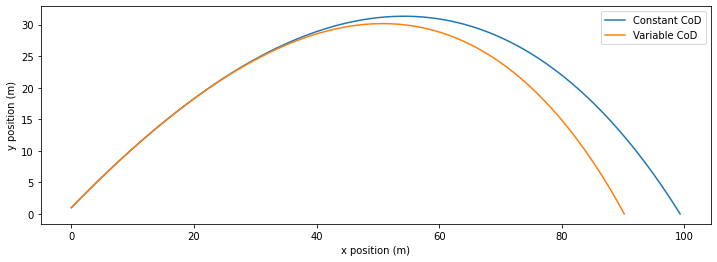

In [ ]:
# Plot the trajectory for this simulation and the original one together
# (Hint: you can call plot trajectory twice and it will put the plots on 
# the same graph)

plot_trajectory(results, 'Constant CoD',legend=True)
plot_trajectory(results_var, 'Variable CoD',legend=True)


### Part 5

Describe the results (using numbers!):

✅ A. What is the difference in flight time and total distance if we account for a variable coefficient of drag?

✅ ✅  Answer A here.

✅ B. In answer A, you found the *absolute error* created by our earlier simplification.  Now convert these differences to a *relative error* (sometimes called *percent error*).

✅ ✅ Answer B here.

✅ C. Why might relative error be a more valuable expression of error than absolute error?

✅ ✅ Answer C here.

✅ D. Look back at the plot of the coefficient of drag for a baseball.  How might we have guessed that the ball would fly a shorter distance in our iterated simulation?

✅ ✅ Answer D here.

✅ E. Below is some code that calculates and plots the velocity magnitude of the ball vs. time.  Explain the shape of this plot.  Why is the speed of the ball varying in this way?

✅ ✅ Answer E here

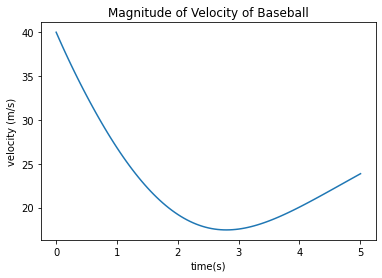

In [ ]:
pythagorean_inside = results_var.vy.values**2 + results_var.vx.values**2
vel_mag = pythagorean_inside**(1/2)
velocity = pd.Series(data=vel_mag, index = results.index)
velocity.plot(title = 'Magnitude of Velocity of Baseball', 
              xlabel='time(s)', ylabel='velocity (m/s)');